In [1]:
import os
import time
import uuid
import cv2
import time
from djitellopy import tello

In [2]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import backend as K

In [3]:
import random
import re

In [4]:
import albumentations as alb

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Resizing, Rescaling, Input, Dense, Lambda, Dropout, Flatten
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing 

In [6]:
new_img_base_path = '../../data/face_detection/new'
raw_img_base_path = '../../data/face_detection/raw'
aug_img_base_path = '../../data/face_detection/augmented'

# Generate data

## Gather images

_Done in drone main.py_

## Label images

_Use label me to draw boxes around all hands and mark with class name (e.g. no_hand, fist etc.)_

In [10]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: /Users/philipwitte/.labelmerc


## Partition new image data 

In [11]:
# Put images into regarding folders (randomly)
# First create list of all file_names
file_list = []
for folder in os.listdir(os.path.join(new_img_base_path, 'not_allocated')):
    if folder != 'labels' and folder[0] != '.':
        for file in os.listdir(os.path.join(new_img_base_path, 'not_allocated', folder)):
            if re.findall(r'\.jpg', file):
                file_list.append([folder, file])
len(file_list)

0

In [12]:
# ... then define sizes of datasets...
train_size = int(0.7 * len(file_list))
val_size = int(0.15 * len(file_list))
test_size = len(file_list) - train_size - val_size

train_size, val_size, test_size

(0, 0, 0)

In [13]:
# ...and finally move files randomly into target folders
for partition, sample_size in zip(['train', 'val', 'test'], [train_size, val_size, test_size]):
    selected_images = random.sample(file_list, sample_size)
    file_list = [image for image in file_list if image not in selected_images]
    for image in selected_images:
        os.rename(os.path.join(new_img_base_path, 'not_allocated', image[0], image[1]), 
                  os.path.join(new_img_base_path, 'images', partition, image[1]))

In [14]:
# ...labels can be shifted accordingly
count_no_labels = 0
for partition in ['train', 'val', 'test']:
    for image in os.listdir(os.path.join(new_img_base_path, 'images', partition)):
        label_name = image[:-3] + 'json'
        try: 
            os.rename(os.path.join(new_img_base_path, 'not_allocated', 'labels', label_name), 
                  os.path.join(new_img_base_path, 'labels', partition, label_name))
        except:
            count_no_labels += 1
print(f'In total {count_no_labels} images without label info.')

In total 0 images without label info.


In [15]:
# ... now shift images and labels into regarding 'raw'-folders
for partition in ['train', 'val', 'test']:
    # Move images
    for image in os.listdir(os.path.join(new_img_base_path, 'images', partition)):
        os.rename(os.path.join(new_img_base_path, 'images', partition, image), 
                  os.path.join(raw_img_base_path, 'images', partition, image))
    # Move labels
    for label in os.listdir(os.path.join(new_img_base_path, 'labels', partition)):
        os.rename(os.path.join(new_img_base_path, 'labels', partition, label), 
                  os.path.join(raw_img_base_path, 'labels', partition, label))

In [16]:
# And delete empty folders
for folder in os.listdir(os.path.join(new_img_base_path, 'not_allocated')):
    if folder != 'labels' and folder[0] != '.':
        for file in os.listdir(os.path.join(new_img_base_path, 'not_allocated', folder)):
            if file[0] == '.':
                os.remove(os.path.join(new_img_base_path, 'not_allocated', folder, file))
        os.rmdir(os.path.join(new_img_base_path, 'not_allocated',folder))

## Review images

In [7]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
X_train = []
images_path = os.path.join(raw_img_base_path, 'images', 'train')

for file in os.listdir(images_path):
    if file[0] != '.': # Filter out 'DS_Store'-objects       
        # load the image
        img = load_img(os.path.join(images_path, file))
        # convert it to an array
        img_array = np.array(img)
        # append the array to X
        X_train.append(img_array)
        
#X_train = np.array(X_train)

In [9]:
X_train[0].shape

(720, 960, 3)

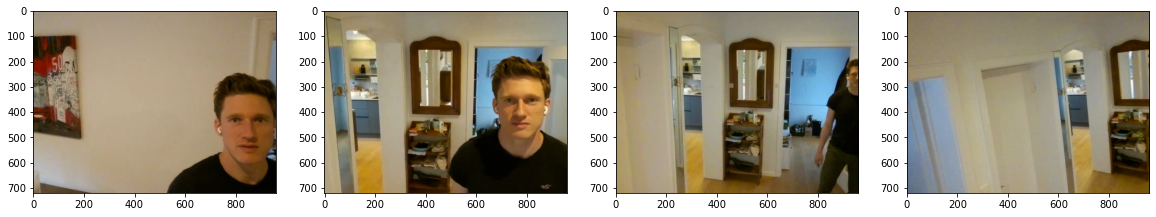

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(X_train[1:32:8]):
    ax[idx].imshow(image)
plt.show()

# Perform image augmentation

## Create augmentor with albumentation

In [11]:
augmentor = alb.Compose([alb.RandomBrightnessContrast((-0.2, 0.2), p=0.3),
                         alb.RandomGamma(p=0.3),
                         alb.RGBShift(p=0.3),
                         alb.HorizontalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

## Use augmentor for a single image

In [12]:
rnd = random.randint(0, 100)
img_name = os.listdir(os.path.join(raw_img_base_path, 'images', 'train'))[rnd]
img_name

'5e5e4030-e635-11ec-9098-8a15287fd427.jpg'

In [13]:
img = cv2.imread(os.path.join(raw_img_base_path, 'images', 'train', img_name))

In [14]:
with open(os.path.join(raw_img_base_path, 'labels', 'train', img_name[:-3]+'json'), 'r') as f:
    label = json.load(f)

In [15]:
type(label)

dict

In [16]:
label['shapes']

[{'label': 'face',
  'points': [[130.0, 345.66666666666663], [257.6190476190476, 519.0]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}}]

In [17]:
class_label = label['shapes'][0]['label']
class_label

'face'

In [18]:
points = label['shapes'][0]['points']
points

[[130.0, 345.66666666666663], [257.6190476190476, 519.0]]

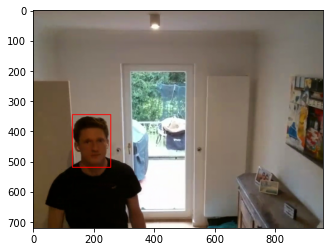

In [19]:
cv2.rectangle(img,
              tuple([int(i) for i in points[0]]),
              tuple([int(i) for i in points[1]]),
              (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [20]:
# Convert coordinates into a one-dimensional list
coords = []
for coord_list in points:
    for coord in coord_list:
        coords.append(coord)
coords

[130.0, 345.66666666666663, 257.6190476190476, 519.0]

In [21]:
# Convert into 'alubmentations' format, i.e. relative to img dimensions
coords = list(np.divide(coords, [960, 720, 960, 720]))
coords

[0.13541666666666666,
 0.4800925925925925,
 0.2683531746031746,
 0.7208333333333333]

In [22]:
# Augment image using the defined augmentor
img = cv2.imread(os.path.join(raw_img_base_path, 'images', 'train', img_name))
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [23]:
# Output is a dictionary
type(augmented)

dict

In [24]:
# Image, bbox and class labels are keys
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

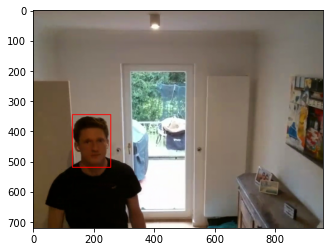

In [25]:
# Draw augmented image incl. bbox
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [960, 720]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [960, 720]).astype(int)),
              (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB))

## Perform augmentation and partition data

In [26]:
for data_type in ['images', 'labels']:
    for partition in ['train', 'val', 'test']:
        for file in os.listdir(os.path.join(aug_img_base_path, data_type, partition)):
                    os.remove(os.path.join(aug_img_base_path, data_type, partition, file))

In [27]:
# Augment images and save in regarding folders augemneted/images and augmented/labels
for partition in ['train', 'val', 'test']:
    partition_dir = os.path.join(raw_img_base_path, 'images', partition)
    for image_name in os.listdir(partition_dir):
      
        # Load image
        image = cv2.imread(os.path.join(partition_dir, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # In case no label is available, coordinates and class_label are predefined
        class_label = 'empty'
        coords = [0.4, 0.4, 0.6, 0.6] # x_max / y_max need to be > 0 for augmentor, later set to 0
        
        # Load label (if exists) and get coordinates of box & class_name
        label_path = os.path.join(raw_img_base_path, 'labels', partition, image_name[:-3] + 'json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            # Get class name
            class_label = label['shapes'][0]['label']
            
            # Get coordinates of bbox and scale them
            i = 0    
            for coord_list in label['shapes'][0]['points']:
                for coord in coord_list:
                    coords[i] = coord
                    i += 1
            coords = list(np.divide(coords, [960, 720, 960, 720]))
            
            # Change points, if max point is saved in first position
            if coords[0] > coords[2]:
                coords = coords[-2:] + coords[:2]
        
        # Save augmented image and annotation file
        try:
            if partition == 'train':    
                for i in range(10):
                    # Utilize augmentor
                    augmented = augmentor(image=image, bboxes=[coords], class_labels=[class_label]) #class_label

                    # Save image
                    image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_RGB2BGR)
                    image_path = os.path.join(aug_img_base_path, 'images', partition, 
                                             image_name[:-3] + f'{i}' + '.jpg')
                    cv2.imwrite(image_path, image_aug)

                    
                    # Create annotation
                    annotation = {}
                    annotation['image'] = image_path

                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0                    ### potentially to be replaced with class_label!!!
                    if os.path.exists(label_path):
                        annotation['bbox'] = list(augmented['bboxes'][0])
                        annotation['class'] = 1                ### potentially to be replaced with class_label!!!

                    # Save annotations
                    with open(os.path.join(aug_img_base_path, 'labels', partition, 
                                           image_name[:-3] + f'{i}' + '.json'), 'w') as f:
                        json.dump(annotation, f)
            else:
                # Save image
                image_path = os.path.join(aug_img_base_path, 'images', partition, 
                                             image_name[:-3] + f'{0}' + '.jpg')
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                cv2.imwrite(image_path, image)


                # Create annotation
                annotation = {}
                annotation['image'] = image_path

                annotation['bbox'] = [0, 0, 0, 0]
                annotation['class'] = 0                    ### potentially to be replaced with class_label!!!

                if os.path.exists(label_path):
                    annotation['bbox'] = coords
                    annotation['class'] = 1                ### potentially to be replaced with class_label!!!

                # Save annotations
                with open(os.path.join(aug_img_base_path, 'labels', partition, 
                                       image_name[:-3] + f'{0}' + '.json'), 'w') as f:
                    json.dump(annotation, f)
                
        
        except Exception as e:
            print(e)
            
# Comment: Labelme saves first click as x_min and second click as x_max. That means if the rectangle has been 
# drawn from right bottom corner to left top corner a error message will be sent by augmentor 

## Build augmentation pipeline (tf.dataset)

In [28]:
# Load image from file
def load_img(jpeg_file):
    byte_img = tf.io.read_file(jpeg_file)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [29]:
# Create tf dataset from images
X = []
for partition in ['train', 'val', 'test']:
    
    # Create a dataset of all files matching a pattern
    X_i = tf.data.Dataset.list_files(os.path.join(aug_img_base_path, 'images', partition, '*.jpg'), 
                                         shuffle=False)
    # Read file and decode into jpeg format
    X_i = X_i.map(load_img)
    
    # Save in list 
    X.append(X_i)

X_train = X[0]
X_val = X[1]
X_test = X[2]

In [30]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [31]:
#X_train.as_numpy_iterator().next()

In [32]:
# Function to load json files
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [33]:
# Create tf dataset for labels
y = []
for partition in ['train', 'val', 'test']:
    # Create a dataset of all files matching a pattern
    y_i = tf.data.Dataset.list_files(os.path.join(aug_img_base_path, 'labels', partition, '*.json'), 
                                         shuffle=False)
    
    # Read file and decode into jpeg format (py_function wraps a python function into a TensorFlow op)
    y_i = y_i.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float32]))
    
    # Save in list 
    y.append(y_i)

y_train = y[0]
y_val = y[1]
y_test = y[2]

In [34]:
type(y_train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [35]:
y_train.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float32))

In [36]:
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(1400, 1400, 30, 30, 30, 30)

In [37]:
### Define batch size here!!! ###

In [38]:
# Create final dataset by zipping images and labels
data = []
for X, y in zip([X_train, X_val, X_test], [y_train, y_val, y_test]):
    # Zip data together
    data_i = tf.data.Dataset.zip((X, y))
    # Shuffle images
    data_i = data_i.shuffle(4000)
    # Batch contains x images + labels
    data_i = data_i.batch(32)
    # Prefetch helps eliminate bottlenecks
    data_i = data_i.prefetch(16)
    
    data.append(data_i)
    
data_train = data[0]
data_val = data[1]
data_test = data[2]   

In [39]:
# Expected: 8 images, 240*360, 3 channels
data_train.as_numpy_iterator().next()[0].shape

(32, 720, 960, 3)

## Review augmented images and bboxes

In [40]:
data_samples = data_train.as_numpy_iterator()

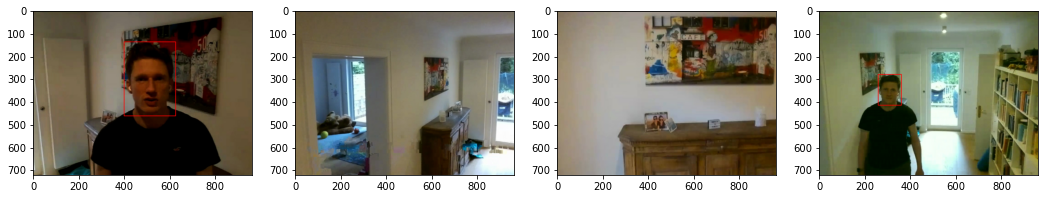

In [41]:
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(18, 12))

for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [960, 720]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [960, 720]).astype(int)),
                  (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# Build neuronal network

## Create NN model

In [42]:
K.clear_session()

In [43]:
vgg = VGG16(include_top=False, pooling='avg')
vgg.trainable = False

In [44]:
# Use convolutional layers from mobile net as base model
mobilenet = mobilenet_v2.MobileNetV2( 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False  # <------ !!!!! we only want to have the base, not the final dense layers 
)
mobilenet.trainable = False

In [45]:
base_model = vgg

In [46]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [47]:
def build_model():
    input_layer = Input(shape=(720, 960, 3))
    
    preprocessing_layer = Resizing(224, 224)(input_layer)
    preprocessing_layer = Rescaling(1./255)(preprocessing_layer)
    
    base_model_output = base_model(preprocessing_layer)
    
    class_layer = Dense(2048, activation='relu')(base_model_output) #2048
    class_layer = Dense(1, activation='sigmoid')(class_layer)
    
    reg_layer = Dense(2048, activation='relu')(base_model_output)
    reg_layer = Dense(4, activation='sigmoid')(reg_layer) 
    
    model = Model(inputs=input_layer, outputs=[class_layer, reg_layer])
    
    return model

In [48]:
def build_model():
    input_layer = Input(shape=(720, 960, 3))
    
    preprocessing_layer = Resizing(224,224)(input_layer)
    preprocessing_layer = Rescaling(1./255)(preprocessing_layer)
    
    base_model_output = base_model(preprocessing_layer)
    
    class_layer = Dense(512, activation='relu')(base_model_output)
    class_layer = Dense(1, activation='sigmoid')(class_layer)
    
    reg_layer = Dense(512, activation='relu')(base_model_output)
    reg_layer = Dense(128, activation='relu')(reg_layer)
    reg_layer = Dense(32, activation='relu')(reg_layer)
    reg_layer = Dense(4, activation='sigmoid')(reg_layer) 
    
    model = Model(inputs=input_layer, outputs=[class_layer, reg_layer])
    
    return model

In [49]:
face_tracker = build_model()

In [50]:
face_tracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 720, 960, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['resizing[0][0]']               
                                                                                                  
 vgg16 (Functional)             (None, 512)          14714688    ['rescaling[0][0]']          

In [51]:
X, y = data_train.as_numpy_iterator().next()

In [52]:
X.shape

(32, 720, 960, 3)

In [53]:
y

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.66914684, 0.3438492 , 0.76339287, 0.5091931 ],
        [0.34871033, 0.18776456, 0.58382934, 0.6401455 ],
        [0.35664684, 0.3306217 , 0.48660713, 0.5541667 ],
        [0.04910714, 0.23670635, 0.31498015, 0.71951056],
        [0.00104167, 0.2539021 , 0.05406746, 0.43194443],
        [0.79414684, 0.3901455 , 0.9985119 , 0.8134259 ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.45089287, 0.4390873 , 0.59474206, 0.67453706],
        [0.23363096, 0.3359127 , 0.32093254, 0.

In [54]:
classes, coords = face_tracker.predict(X)
classes, coords

(array([[0.34421146],
        [0.3648309 ],
        [0.3386857 ],
        [0.32216743],
        [0.3446488 ],
        [0.35130778],
        [0.34851128],
        [0.34335086],
        [0.33073974],
        [0.33632684],
        [0.3465431 ],
        [0.34553128],
        [0.3490812 ],
        [0.34988028],
        [0.34037986],
        [0.3497656 ],
        [0.35142413],
        [0.32469967],
        [0.34357494],
        [0.3394566 ],
        [0.35871378],
        [0.35453832],
        [0.3466079 ],
        [0.34463707],
        [0.35925275],
        [0.33400583],
        [0.34533486],
        [0.35683534],
        [0.32816318],
        [0.35187125],
        [0.34053603],
        [0.33755025]], dtype=float32),
 array([[0.44351253, 0.54809225, 0.48469406, 0.45590305],
        [0.44788426, 0.554949  , 0.48579606, 0.46119565],
        [0.45484066, 0.5525151 , 0.49468488, 0.4612485 ],
        [0.4411989 , 0.5631315 , 0.47312862, 0.4642272 ],
        [0.44991666, 0.5589592 , 0.46671405, 0.

## Define loss functions

In [59]:
# Define localization loss
def localization_loss(y_true, y_pred):
    """
    Calculates loss function for boundary box. Input needs to be nested list / numpy array with shape (1,4)
    """
    # Calculate delta for x_min/y_min coordinate (top left corner)
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))
    
    # Calculate difference in terms of width and height
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [60]:
# Define loss functions for model
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [61]:
# Test classloss
classloss(y[0], classes).numpy()

0.8327492

In [62]:
# Test regressloss
regressloss(y[1], coords).numpy()

13.161938

## Define model subclass and compile model

In [63]:
class FaceTracker(Model):
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        
    def compile(self, opt, classloss, regressloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.rloss = regressloss
        self.opt = opt
        
    def train_step(self, batch, **kwargs):
        
        X, y = batch
        
        with tf.GradientTape() as tape:
            # Make a prediction
            classes, coords = self.model(X, training=True)
            
            # Calculate losses (y vs. prediction)
            batch_closs = self.closs(y[0], classes)
            batch_rloss = self.rloss(tf.cast(y[1], tf.float32), coords)  # cast can be deleted, once pipeline is rerun
            batch_total_loss = batch_closs + batch_rloss  # factor before batch_lloss to be optimized
            
            # Calculate gradients for trainable variables
            grad = tape.gradient(batch_total_loss, self.model.trainable_variables)
          
        # Change trainable variables in direction of gradient using opt algorithm 
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {'total_loss':batch_total_loss, 'class_loss':batch_closs, 'regression_loss':batch_rloss}
    
    def test_step(self, batch, **kwargs):
        
        X, y = batch
        
        # Make a prediction
        classes, coords = self.model(X, training=True)

        # Calculate losses (y vs. prediction) -> no gradient descent!!
        batch_closs = self.closs(y[0], classes)
        batch_rloss = self.rloss(y[1], coords)
        batch_total_loss = batch_closs + batch_rloss  # factor before batch_lloss to be optimized

        return {'total_loss':batch_total_loss, 'class_loss':batch_closs, 'regression_loss':batch_rloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [64]:
face_tracker = build_model()
model = FaceTracker(face_tracker)

In [65]:
# Determine optimizer
opt = Adam(0.0001) #, decay=0.00001) # (learning_rate=0.0001, decay=lr_decay) # Make sure Adam is loaded from tensorflow keras!!

In [66]:
model.compile(opt, classloss, regressloss)

## Train model

In [67]:
log_dir = 'logs'

In [68]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [69]:
history = model.fit(data_train, epochs=40, validation_data=data_val, callbacks=[tensorboard_callback])

Epoch 1/40
44/44 [==============================] - 38s 681ms/step - total_loss: 6.8324 - class_loss: 0.6583 - regression_loss: 6.1741 - val_total_loss: 4.3131 - val_class_loss: 0.6486 - val_regression_loss: 3.6645
Epoch 2/40
44/44 [==============================] - 32s 644ms/step - total_loss: 5.0229 - class_loss: 0.5726 - regression_loss: 4.4503 - val_total_loss: 3.9170 - val_class_loss: 0.5684 - val_regression_loss: 3.3486
Epoch 3/40
44/44 [==============================] - 33s 674ms/step - total_loss: 4.6521 - class_loss: 0.5040 - regression_loss: 4.1482 - val_total_loss: 3.5436 - val_class_loss: 0.5002 - val_regression_loss: 3.0434
Epoch 4/40
44/44 [==============================] - 34s 671ms/step - total_loss: 4.2135 - class_loss: 0.4424 - regression_loss: 3.7711 - val_total_loss: 3.2054 - val_class_loss: 0.4495 - val_regression_loss: 2.7558
Epoch 5/40
44/44 [==============================] - 34s 685ms/step - total_loss: 3.8219 - class_loss: 0.3910 - regression_loss: 3.4309 - val

44/44 [==============================] - 52s 1s/step - total_loss: 0.6134 - class_loss: 0.0440 - regression_loss: 0.5695 - val_total_loss: 0.6612 - val_class_loss: 0.1103 - val_regression_loss: 0.5509
Epoch 40/40
44/44 [==============================] - 44s 890ms/step - total_loss: 0.6113 - class_loss: 0.0432 - regression_loss: 0.5681 - val_total_loss: 0.6585 - val_class_loss: 0.1103 - val_regression_loss: 0.5482


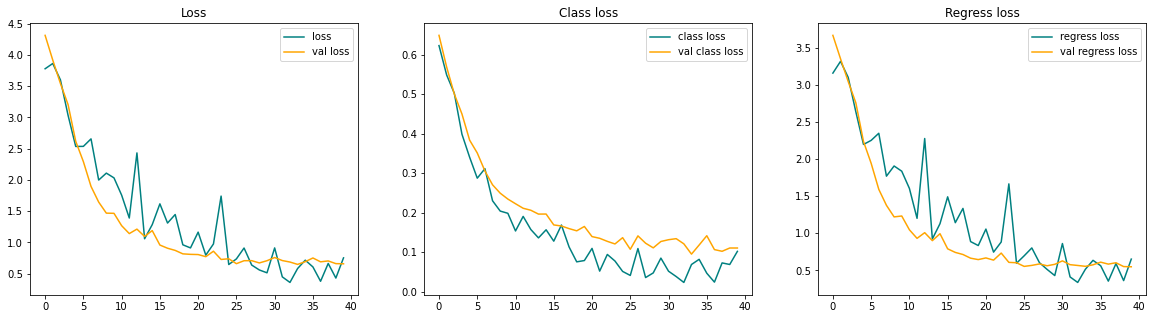

In [71]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='teal', label='loss')
ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['class_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Class loss')
ax[1].legend()

ax[2].plot(history.history['regression_loss'], color='teal', label='regress loss')
ax[2].plot(history.history['val_regression_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regress loss')
ax[2].legend()


## Make predictions

In [72]:
face_tracker = model.model

In [121]:
data_test_iterator = data_test.as_numpy_iterator()

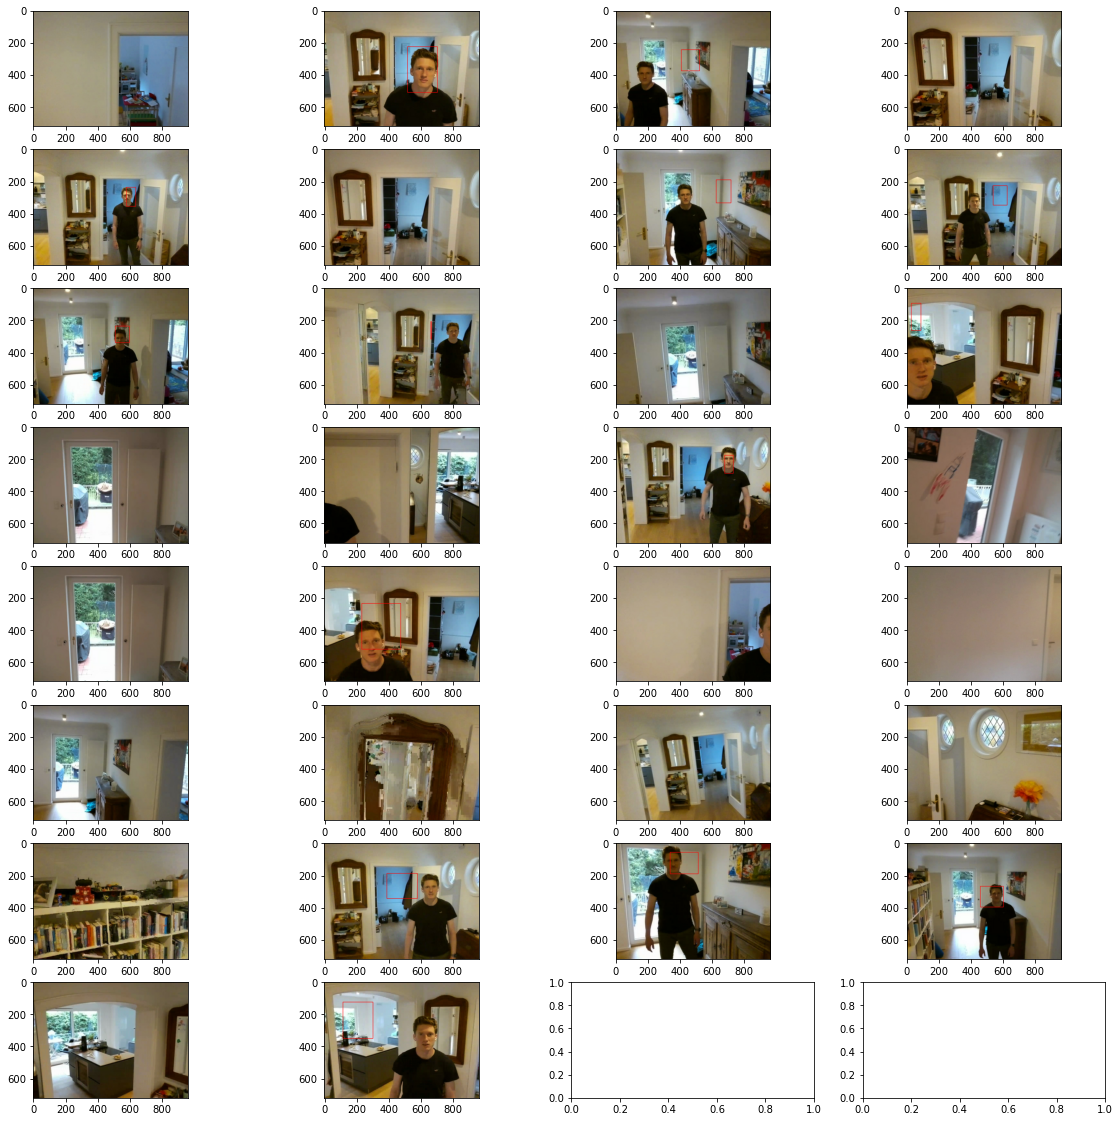

In [122]:
test_sample = data_test_iterator.next()
y_pred = face_tracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, nrows=8, figsize=(20,20))
row = 0
for idx in range(30):
    sample_image = test_sample[0][idx]
    sample_coords = y_pred[1][idx]
    if y_pred[0][idx, 0] > 0.5:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [960, 720]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [960, 720]).astype(int)),
                      (255,0,0), 2)   
    ax[idx // 4, idx % 4].imshow(sample_image)

In [586]:
face_tracker.save('face_tracker.h5')

# Perform real time detection

In [405]:
from tensorflow.keras.models import load_model

In [406]:
# Load model from h5 file hand_detection_model.ipynbre for testing purposes)
face_tracker = load_model('face_tracker.h5')

In [407]:
# Image capturing with Tello drone for real time testing

from datetime import datetime, timedelta

me = tello.Tello()
me.connect()
print(me.get_battery())

# Triger stream from drone
me.streamon()

# Initialize variables
datetime_prv = datetime.now() - timedelta(seconds=1)
prob_class_1 = 0

# Start streaming
while True:
    img = me.get_frame_read().frame
    img = cv2.resize(img, (360, 240))
    
    if datetime.now() >= datetime_prv + timedelta(seconds=0.5):
        img_trf = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_trf = img_trf.reshape(1, 240, 360, 3)
        y_pred = face_tracker.predict(img_trf)
        coords = y_pred[1][0]
        prob_class_1 = y_pred[0][0, 1]
    
    if prob_class_1 > 0.5:
        
        # Draw bbox around hand
        cv2.rectangle(img,
                      tuple(np.multiply(coords[:2], [360, 240]).astype(int)),
                      tuple(np.multiply(coords[2:], [360, 240]).astype(int)),
                      (255,0,0), 2)
        
        # Draw label box
        cv2.rectangle(img,
                      tuple(np.add(np.multiply(coords[:2], [360, 240]).astype(int), [0, -30])),
                      tuple(np.add(np.multiply(coords[:2], [360, 240]).astype(int), [80, 0])),
                      (255,0,0), -1)
        
        # Put text in label
        cv2.putText(img, 'straight_hand', 
                    tuple(np.add(np.multiply(coords[:2], [360, 240]).astype(int), [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                   
    cv2.imshow("Image", img)
    cv2.waitKey(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

me.streamoff()
cv2.destroyAllWindows()

[INFO] tello.py - 122 - Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
[INFO] tello.py - 437 - Send command: 'command'
[WARNING] tello.py - 447 - Aborting command 'command'. Did not receive a response after 7 seconds
[INFO] tello.py - 437 - Send command: 'command'
[WARNING] tello.py - 447 - Aborting command 'command'. Did not receive a response after 7 seconds
[INFO] tello.py - 437 - Send command: 'command'
[WARNING] tello.py - 447 - Aborting command 'command'. Did not receive a response after 7 seconds


Exception: Command 'command' was unsuccessful for 4 tries. Latest response:	'Aborting command 'command'. Did not receive a response after 7 seconds'